In [1]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /home/nitiz/Desktop/notebooks/PyTorch/LSTM_Autoencoders/ECG5000.zip
100%|██████████████████████████████████████| 10.6M/10.6M [00:01<00:00, 10.5MB/s]


In [2]:
!unzip -qq ECG5000.zip

In [13]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import load


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
with open('ECG5000_TRAIN.arff') as f:
    train = load(f)
    
with open('ECG5000_TEST.arff') as f:
    test = load(f)

In [21]:
df = pd.concat([train,test])
df = df.sample(frac = 1.0)
df.shape

(5000, 141)

In [22]:
CLASS_NORMAL = 1

class_names = ['Normal', 'R on T', 'PVC' , 'SP' , 'UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
976,0.293792,-2.383951,-4.176308,-5.137171,-4.425039,-3.184913,-1.806514,-1.459647,-1.175809,-0.185755,...,1.638510,1.636886,1.650433,1.290564,0.582950,0.125927,0.043958,0.989223,-0.171944,1
4481,-0.190965,-0.591521,-0.534729,-1.045398,-1.415360,-1.655263,-1.746477,-1.580662,-1.310005,-0.916262,...,-3.139261,-3.484997,-3.972832,-4.009499,-3.477025,-2.642491,-1.452003,-1.025910,-0.065651,2
2188,-0.650574,-3.967055,-4.733719,-4.498967,-3.857604,-2.569738,-1.708551,-1.557044,-0.769476,-0.143569,...,1.305516,1.476687,1.523373,1.671012,0.961871,0.517006,0.138329,0.926117,-0.828718,1
2643,-0.255789,-0.753022,-0.910341,-1.539924,-1.818217,-1.998055,-2.228205,-2.209918,-2.086697,-1.927978,...,-3.300453,-3.803324,-3.797474,-3.222609,-2.578747,-1.655294,-1.016267,-1.192168,-0.092274,2
1951,-0.444090,-1.800048,-2.752843,-3.641728,-4.284840,-4.160666,-3.228747,-1.864852,-1.486588,-0.923568,...,1.437768,0.819710,0.002099,-1.168150,-1.866950,-1.947785,-1.746563,-0.844451,-0.859443,1


In [23]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

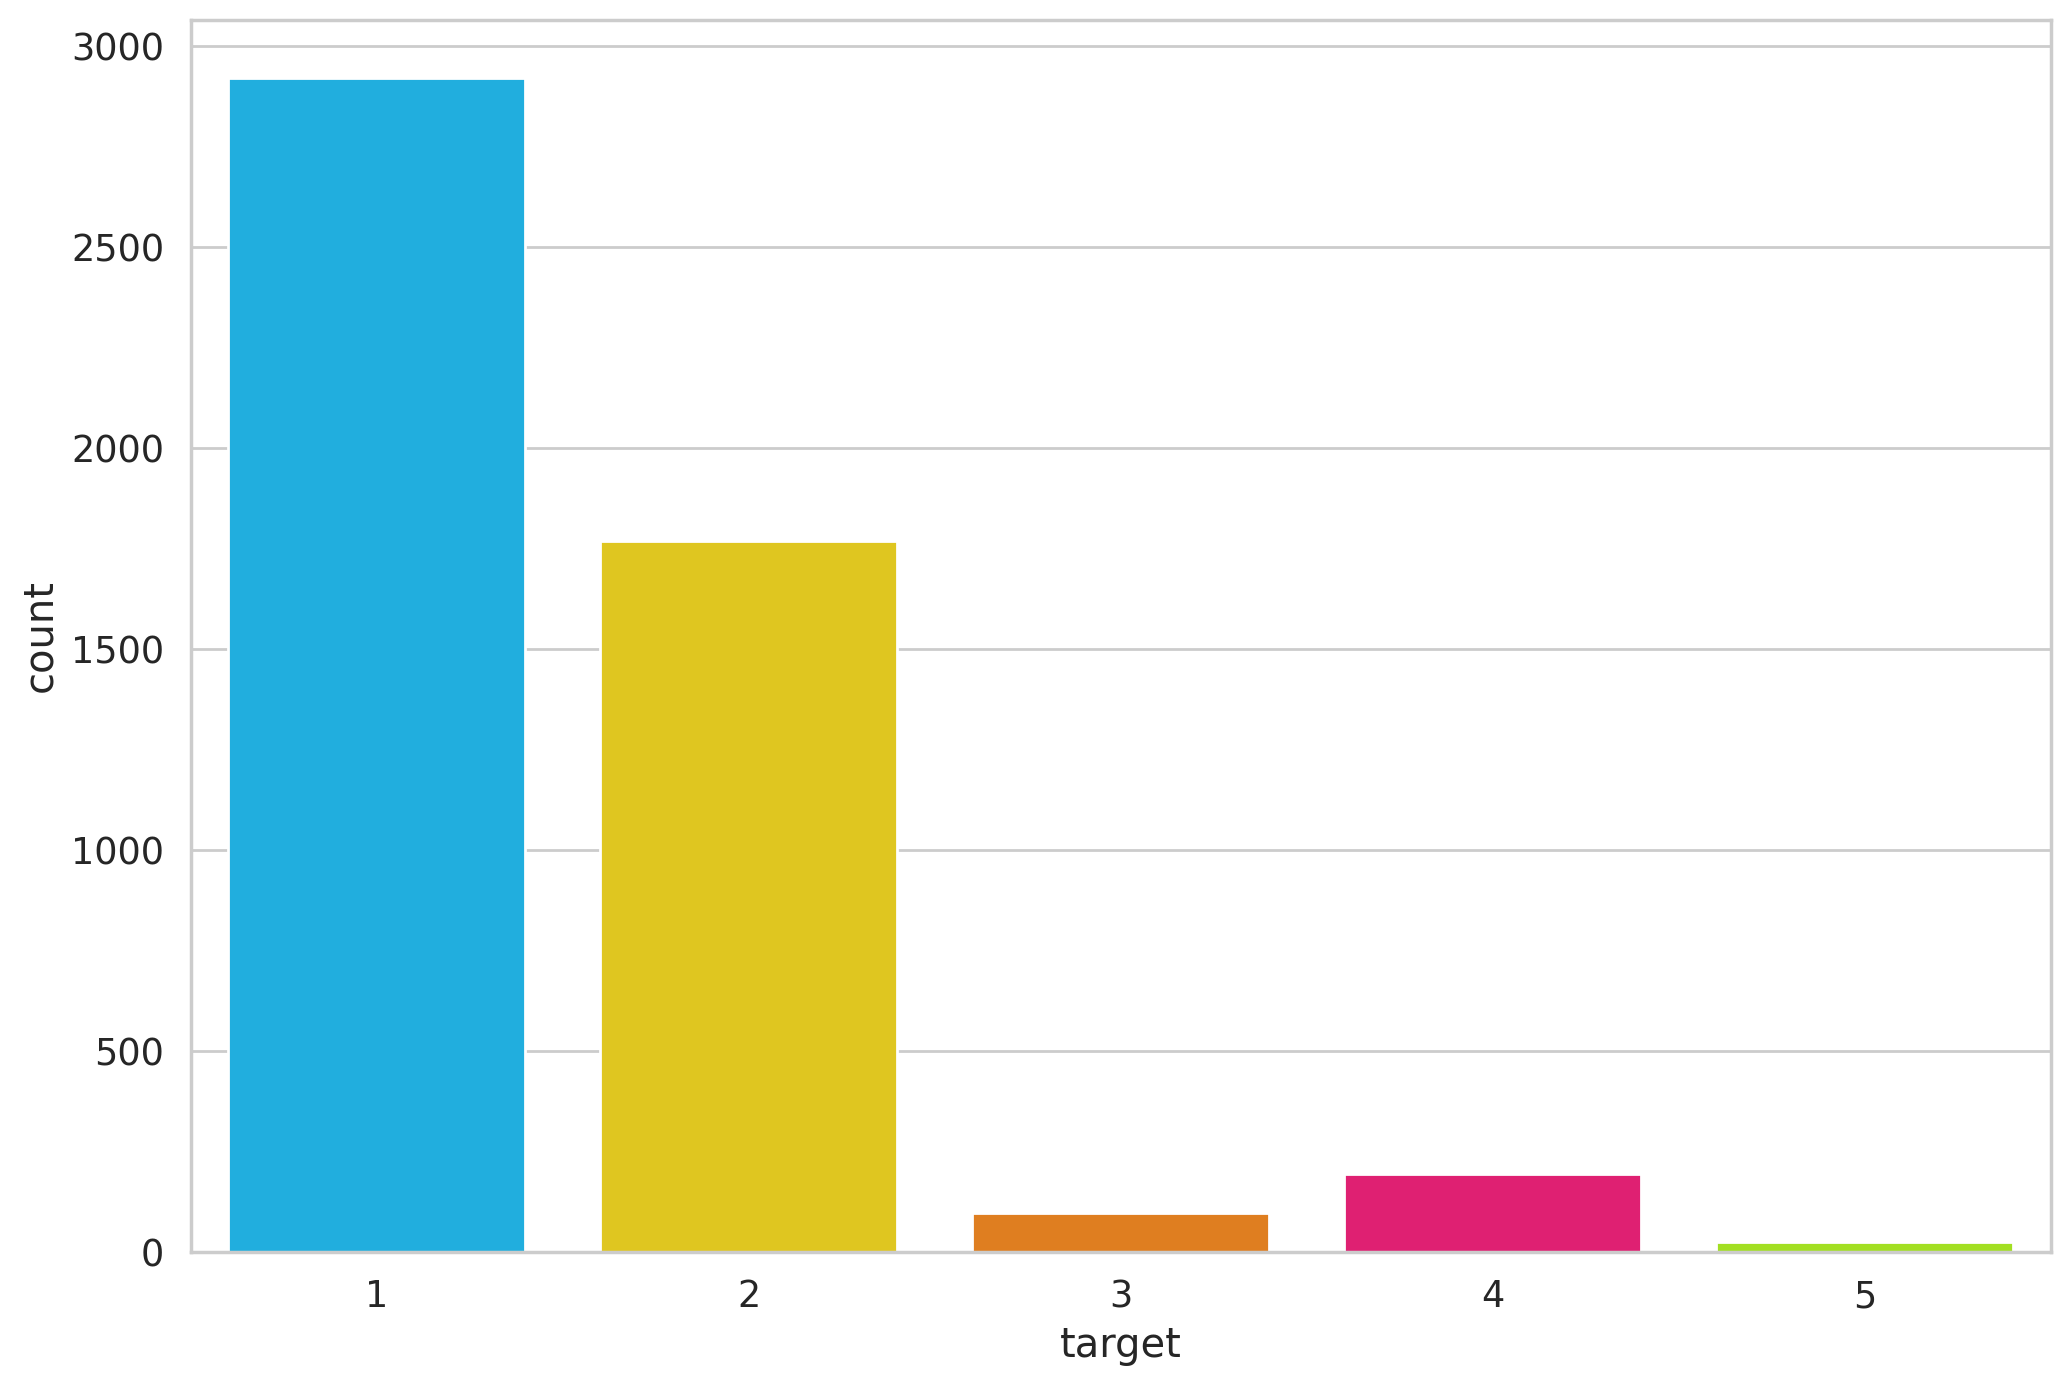

In [33]:
sns.countplot(x=df["target"])

In [34]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels = 'target' , axis = 1)
normal_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
976,0.293792,-2.383951,-4.176308,-5.137171,-4.425039,-3.184913,-1.806514,-1.459647,-1.175809,-0.185755,...,1.996036,1.638510,1.636886,1.650433,1.290564,0.582950,0.125927,0.043958,0.989223,-0.171944
2188,-0.650574,-3.967055,-4.733719,-4.498967,-3.857604,-2.569738,-1.708551,-1.557044,-0.769476,-0.143569,...,0.505377,1.305516,1.476687,1.523373,1.671012,0.961871,0.517006,0.138329,0.926117,-0.828718
1951,-0.444090,-1.800048,-2.752843,-3.641728,-4.284840,-4.160666,-3.228747,-1.864852,-1.486588,-0.923568,...,1.514474,1.437768,0.819710,0.002099,-1.168150,-1.866950,-1.947785,-1.746563,-0.844451,-0.859443
421,-1.583958,-3.608669,-4.026130,-4.171160,-3.643043,-2.578296,-1.707883,-1.475232,-0.940579,-0.328065,...,0.956064,1.321269,1.413952,1.850296,2.016815,1.699100,1.121295,0.911809,1.593821,0.652045
2217,-0.824645,-2.247977,-3.101425,-4.031799,-4.535630,-4.123692,-3.306067,-2.100078,-1.650539,-1.263662,...,1.192339,1.164879,0.907984,0.051693,-0.732408,-1.215220,-0.960531,-0.637974,-0.346375,-1.361857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,-1.050459,-3.138098,-3.799888,-4.253500,-3.880034,-2.872927,-1.796985,-1.644777,-1.131807,-0.393713,...,0.864286,1.108095,1.190584,1.523453,1.585989,1.423378,1.292335,1.613520,2.257046,0.340466
1982,0.061736,-1.367496,-1.140372,-1.823207,-1.463851,-0.953350,0.149469,0.457749,0.875301,1.363336,...,1.286828,1.752019,1.690061,1.192924,0.123239,-1.946875,-3.561686,-4.644772,-4.103030,-4.232866
755,-0.526821,-3.359393,-4.225134,-4.419806,-4.035850,-2.810712,-1.903804,-1.787840,-1.347151,-0.533522,...,0.490886,1.334494,1.454381,1.227361,1.039723,0.491605,0.208097,-0.025773,0.966789,0.147113
1604,-1.561344,-3.467261,-3.792775,-4.135948,-3.936675,-3.266455,-2.124746,-1.510954,-1.398323,-0.912323,...,1.801694,1.553584,1.288870,0.791333,0.336976,-0.015600,-0.324919,-0.259701,0.200054,-0.526266


In [36]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels = 'target', axis =1)
anomaly_df.shape

(2081, 140)

In [38]:
train_df, val_df = train_test_split(
    normal_df,
    test_size = 0.15,
    random_state = RANDOM_SEED
)

val_df, test_df = train_test_split(
    val_df,
    test_size = 0.33,
    random_state=RANDOM_SEED
)

In [79]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [80]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [81]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))

In [82]:
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [83]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [84]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [85]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
        for seq_true in val_dataset:

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=150
)

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();